### Environment setup

**What this cell should do:**
- Set up the Python environment for the Kaggle notebook.

---


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pathlib import Path
import librosa
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor, WavLMModel

import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-11-27 10:56:42.424489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764241002.445830   91483 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764241002.452309   91483 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_49.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_67_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_90.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_77.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_20_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_54.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_106_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_42.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_81.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_107.wav
/kaggle/input/shl-in

### Dataset Paths

**What this cell should do:**
- Defines paths to train/test CSVs and audio directories.

---


In [2]:
TRAIN_CSV = Path("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv")
TEST_CSV = Path("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv")

TRAIN_AUDIO_DIR = Path("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train")
TEST_AUDIO_DIR = Path("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test")


### Hyperparameters

**What this cell should do:**
- Assigning all the hyperparameter variables.

---


In [3]:
CHUNK_SEC = 2.0 # segment length in seconds
SR = 16000
CHUNK_SIZE = int(CHUNK_SEC * SR)
BATCH_SIZE = 4
ACCUM_STEPS = 4
EPOCHS = 10
LR = 2e-5
NUM_WORKERS = 2

### Model Selection

**What this cell should do:**
- Assigns the selected model to cuda or cpu.

---


In [4]:
MODEL_NAME = "microsoft/wavlm-base" # WavLM base model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


### Feature Extractor

**What this cell should do:**
- Assigns the feature extractor of the pretrained model to a variable.

---


In [5]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)

### Audio Dataset loader

**What this cell should do:**
- Defines a PyTorch  class that loads audio files, normalizes their length, extracts features, and returns tensors (with labels for training).

---


In [6]:
class AudioDataset(Dataset):
    def __init__(self, df, audio_dir, labels=True, fixed_length=CHUNK_SIZE):
        self.df = df.reset_index(drop=True)
        self.audio_dir = Path(audio_dir)
        self.labels = labels
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.df)

    def _resolve_path(self, fname):
        path = self.audio_dir / fname
        if path.exists():
            return path
        wav_path = self.audio_dir / (fname + ".wav")
        if wav_path.exists():
            return wav_path
        alt = Path(fname)
        if alt.exists():
            return alt
        raise FileNotFoundError(f"File not found: {fname} or {fname}.wav in {self.audio_dir}")

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = str(row.filename)
        path = self._resolve_path(fname)
        y, _ = librosa.load(str(path), sr=SR)
        if len(y) < self.fixed_length:
            y = np.pad(y, (0, self.fixed_length - len(y)))
        else:
            y = y[:self.fixed_length]
        # feature extractor + return tensor
        inputs = feature_extractor(y, sampling_rate=SR, return_tensors="pt", padding=True)
        audio = inputs['input_values'][0]
        if self.labels:
            label = float(row.label)
            return audio, torch.tensor(label, dtype=torch.float32)
        else:
            return audio, fname

### Audio Regression Model Using WavLM

**What this cell should do:**
- This cell defines a regression model built on top of WavLM.

---


In [7]:
class WavLMRegressor(nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super().__init__()
        self.wavlm = WavLMModel.from_pretrained(model_name)
        hidden = self.wavlm.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        out = self.wavlm(x).last_hidden_state  # (B, seq_len, hidden)
        emb = out.mean(dim=1)                  # (B, hidden)
        return self.head(emb).squeeze(1)      # (B,)

### Utility functions

**What this cell should do:**
- This cell defines a safe collate function to stack audio tensors and a validation function that runs the model in no-grad mode which computes RMSE and Pearson correlation.

---


In [8]:
def safe_collate(batch):
    audios = [b[0] for b in batch]
    if isinstance(batch[0][1], str):
        labels = [b[1] for b in batch]
        audios = torch.stack(audios)
        return audios, labels
    else:
        labels = torch.stack([b[1] for b in batch])
        audios = torch.stack(audios)
        return audios, labels

@torch.no_grad()
def validate(model, loader, has_labels=True):
    model.eval()
    preds = []
    trues = []
    for batch in loader:
        # normalize batch
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            audio = batch[0]
            lbl = batch[1] if has_labels else None
        else:
            audio = batch
            lbl = None
        # unwrap nested
        if isinstance(audio, (list, tuple)):
            audio = audio[0]
        if not isinstance(audio, torch.Tensor):
            audio = torch.tensor(audio, dtype=torch.float32)
        audio = audio.to(DEVICE)
        if has_labels and isinstance(lbl, torch.Tensor):
            lbl = lbl.to(DEVICE)
        else:
            lbl = None
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            p = model(audio)
        preds.append(p.detach().cpu().numpy())
        if lbl is not None:
            trues.append(lbl.detach().cpu().numpy())

    # flatten
    if len(preds) > 0:
        preds = np.concatenate([np.asarray(x).reshape(-1) for x in preds])
    else:
        preds = np.array([])

    if trues:
        trues = np.concatenate([np.asarray(x).reshape(-1) for x in trues])
        rmse = mean_squared_error(trues, preds, squared=False)
        r2 = r2_score(trues, preds)
        print(f"Validation -> RMSE: {rmse:.4f}, R2: {r2:.4f}")
    else:
        rmse, r2 = None, None
        print("Validation -> no ground-truth targets found in loader; returning predictions only.")

    return rmse, r2, preds

### Load Train/Test CSVs

**What this cell should do:**
- This cell loads the training and test CSV files.

---


In [9]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
if 'label' not in train_df.columns:
    for c in ['score','grammar_score','mos','mos_score']:
        if c in train_df.columns:
            train_df = train_df.rename(columns={c:'label'})
            break
assert 'label' in train_df.columns, "train.csv must have a label column named 'label'"

### Cross-Validation pipeline

**What this cell should do:**
- This cell runs a full 5-fold cross-validation pipeline: creating dataset splits, loading audio batches, training the WavLMRegressor with mixed-precision, tracking the best validation RMSE per fold and generating the output predictions.

---


Fold 5 | Epoch 10/10 | train_loss=0.7260 | val_rmse=0.7783325910568237 | val_r2=-0.022158859195317904


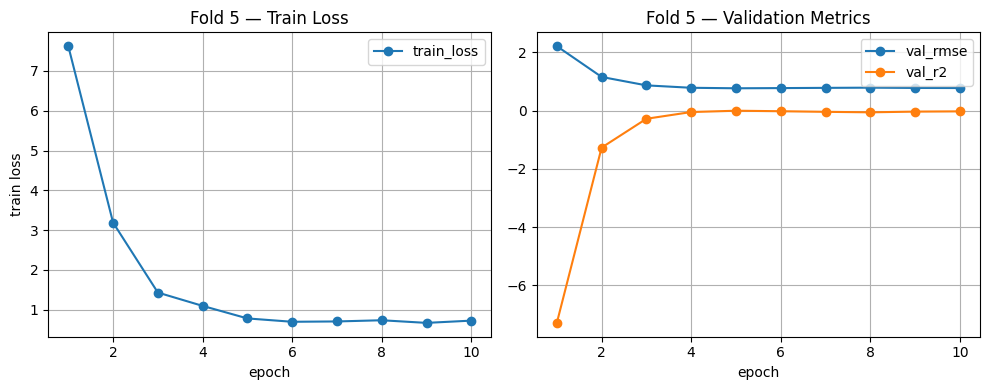

Validation -> no ground-truth targets found in loader; returning predictions only.


,train_loss_mean,train_loss_std,val_rmse_mean,val_rmse_std,val_r2_mean,val_r2_std
epoch,,,,,,
1,7.698766,0.435110,2.121900,0.269825,-7.012839,1.438602
2,2.853574,0.648570,1.075797,0.223069,-1.102323,0.773718
3,1.243264,0.367102,0.849461,0.087717,-0.289236,0.234794
4,0.918380,0.241946,0.790466,0.050822,-0.114209,0.115814
5,0.756012,0.127392,0.776302,0.061229,-0.075576,0.147274
6,0.746922,0.071319,0.773956,0.061320,-0.067655,0.130842
7,0.722094,0.050989,0.788524,0.059358,-0.113979,0.190101
8,0.675544,0.054908,0.787370,0.050467,-0.107551,0.142383
9,0.678082,0.043676,0.777188,0.054581,-0.074692,0.087174


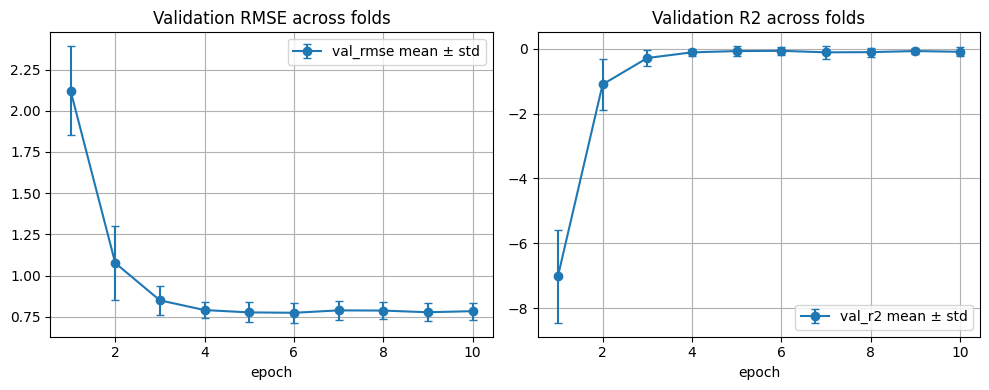

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
test_preds = np.zeros(len(test_df))

all_folds_metrics = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(train_df), start=1):
    print(f"----- Fold {fold} -----")
    tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
    va_df = train_df.iloc[va_idx].reset_index(drop=True)

    train_ds = AudioDataset(tr_df, TRAIN_AUDIO_DIR, labels=True)
    val_ds   = AudioDataset(va_df, TRAIN_AUDIO_DIR, labels=True)
    test_ds  = AudioDataset(test_df, TEST_AUDIO_DIR, labels=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=safe_collate)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=safe_collate)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=safe_collate)

    model = WavLMRegressor().to(DEVICE)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler()

    best_rmse = 1e9
    best_model = None

    # per-epoch metrics for this fold
    fold_metrics = []

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        n_samples = 0

        for i, batch in enumerate(train_loader):
            # handle collated batch
            audio = batch[0]
            label = batch[1]
            if isinstance(label, list):
                label = torch.tensor(label, dtype=torch.float32)
            if isinstance(audio, (list, tuple)):
                audio = audio[0]
            if not isinstance(audio, torch.Tensor):
                audio = torch.tensor(audio, dtype=torch.float32)
            audio = audio.to(DEVICE)
            if not isinstance(label, torch.Tensor):
                label = torch.tensor(label, dtype=torch.float32)
            label = label.to(DEVICE)

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                preds = model(audio)
                loss = F.mse_loss(preds.squeeze(), label.squeeze())

            # gradient accumulation
            scaler.scale(loss / ACCUM_STEPS).backward()
            running_loss += loss.item() * (label.shape[0] if hasattr(label, "shape") else 1)
            n_samples += (label.shape[0] if hasattr(label, "shape") else 1)

            if (i + 1) % ACCUM_STEPS == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()

        avg_train_loss = running_loss / n_samples if n_samples > 0 else float("nan")

        # validate on validation set
        val_rmse, val_r2, _ = validate(model, val_loader, has_labels=True)

        # append epoch metrics
        fold_metrics.append({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_rmse": val_rmse,
            "val_r2": val_r2
        })

        # update best model
        if val_rmse is not None and val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = model

        # Visualization
        clear_output(wait=True)
        print(f"Fold {fold} | Epoch {epoch}/{EPOCHS} | train_loss={avg_train_loss:.4f} | val_rmse={val_rmse} | val_r2={val_r2}")
        df_epoch = pd.DataFrame(fold_metrics).set_index("epoch")
        plt.figure(figsize=(10,4))

        # left: losses (train)
        plt.subplot(1,2,1)
        plt.plot(df_epoch.index, df_epoch["train_loss"], marker="o", label="train_loss")
        plt.xlabel("epoch"); plt.ylabel("train loss"); plt.title(f"Fold {fold} — Train Loss")
        plt.grid(True)
        plt.legend()

        # right: val metrics
        plt.subplot(1,2,2)
        if df_epoch["val_rmse"].notna().any():
            plt.plot(df_epoch.index, df_epoch["val_rmse"], marker="o", label="val_rmse")
        if df_epoch["val_r2"].notna().any():
            plt.plot(df_epoch.index, df_epoch["val_r2"], marker="o", label="val_r2")
        plt.xlabel("epoch"); plt.title(f"Fold {fold} — Validation Metrics")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    all_folds_metrics.append(pd.DataFrame(fold_metrics).assign(fold=fold))

    # inference on test
    if best_model is None:
        best_model = model
    _, _, fold_preds = validate(best_model, test_loader, has_labels=False)
    test_preds += fold_preds / kf.n_splits

# combine metrics
combined = pd.concat(all_folds_metrics, ignore_index=True)

summary = combined.groupby("epoch").agg({
    "train_loss": ["mean","std"],
    "val_rmse": ["mean","std"],
    "val_r2": ["mean","std"]
})
summary.columns = ["_".join(c) for c in summary.columns]
display(summary)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.errorbar(summary.index, summary["val_rmse_mean"], yerr=summary["val_rmse_std"], marker="o", capsize=3, label="val_rmse mean ± std")
plt.xlabel("epoch"); plt.title("Validation RMSE across folds"); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.errorbar(summary.index, summary["val_r2_mean"], yerr=summary["val_r2_std"], marker="o", capsize=3, label="val_r2 mean ± std")
plt.xlabel("epoch"); plt.title("Validation R2 across folds"); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


### Creating the submission file

**What this cell should do:**
- This cell clips test predictions to the valid scoring range and saves the final submission.csv file.

---


In [11]:
test_preds = np.clip(test_preds, 0.0, 5.0)
order = np.argsort(test_df["filename"].values)
test_df = test_df.iloc[order].reset_index(drop=True)
test_preds = test_preds[order]

sub = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_preds
})

sub.to_csv("submission.csv", index=False)
print("Saved submission.csv in correct filename order!")
print(sub.head())

Saved submission.csv in correct filename order!
    filename     label
0    audio_1  3.020508
1   audio_10  3.019531
2  audio_100  3.020020
3  audio_101  3.020020
4  audio_102  3.020996



## Final Report
****

### Approach
- The task is to make a Grammar scoring audio engine.
- The solution uses a WavLM-based neural regression model trained on audio clips.

### Preprocessing

#### Audio Loading & Normalization

- Raw audio files are loaded from .wav paths using your AudioDataset.

- Variable-length audio is collated using a custom safe_collate function to handle inconsistent shapes.

- All audio tensors are converted to float32 and moved to GPU (DEVICE).

#### Labels

- Labels are loaded per sample, cast to tensor (float32), reshaped appropriately, and normalized only if needed by model head..

### Pipeline architecture
- The end-to-end pipeline used in this project consists of the following stages:

1. **Raw Audio Input**
   - Load `.wav` files from disk
   - Normalize waveform and convert to tensors

2. **Dataset & Collation**
   - Custom `AudioDataset` loads (audio, label)
   - `safe_collate` handles variable-length inputs

3. **Feature Extraction**
   - WavLM backbone extracts contextual speech embeddings

4. **Regression Model (WavLMRegressor)**
   - Pretrained WavLM encoder
   - Linear regression head for final score prediction

5. **Training Loop**
   - MSE loss  
   - AdamW optimizer (LR = 2e–5)  
   - Mixed precision (AMP)  
   - Gradient accumulation  
   - Early stopping via best RMSE

6. **Cross-Validation**
   - 5-fold K-Fold CV  
   - Track best RMSE per fold 

7. **Evaluation & Predictions**
   - RMSE and R² calculated per fold
   - Final test predictions averaged across folds


### Evaluation results
- **RMSE (train):** 0.67
- **RMSE (val):** 0.78
